<a href="https://colab.research.google.com/github/Hramchenko/Handwritting/blob/master/new_proffs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")
print(device)

Device Tesla K80
cuda:0


In [0]:
batch_size = 100

In [0]:
import sys
sys.path.append("./Handwritting/")
from IAMWords import IAMWords
image_width = 1500
image_height = 200
train_set = IAMWords("train", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1)
test_set = IAMWords("test", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1)

Reading ./IAM/words.train.pkl...
Reading finished
Reading ./IAM/words.test.pkl...
Reading finished


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [0]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [0]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [0]:
class FullyConnectedX(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnectedX, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [0]:
batch = train_set.make_batch(use_binarization=False)
data, target = batch
target = target.to(device)
data = data/255.0
data = data.view(batch_size, 1, image_width, image_height).to(device)

In [0]:
class HTREncoder(nn.Module):
    def __init__(self, batchnorm=False, dropout=False):
        super(HTREncoder, self).__init__()
        
        self.convolutions = nn.Sequential(
        ConvLayer([1, 4, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([4, 16, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([16, 32, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([32, 64, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([64, 64, 1], padding=0, stride=(1,11), bn=batchnorm, pool_layer=None))
        
        #self.fc = FullyConnectedX([64*15*49, 64*49*3, 64*49], activation_fn=nn.ReLU())
    
    def forward(self, x):
        h = self.convolutions(x)
        h = h.squeeze(-1)
        #h = h.flatten(start_dim=1)
        #h = self.fc(h)
        #h = F.max_pool2d(h, [1, h.size(1)], padding=[0, 0])
        #h = h.permute([2, 3, 0, 1])[0]
        #h = h.permute([2, 3, 0, 1])
        
        return h
    

In [0]:
encoder = HTREncoder().to(device)

In [0]:
c = encoder(data)
c.shape

torch.Size([100, 64, 92])

In [0]:
64*15*49


47040

In [0]:
def to_onehot(x, n):
    one_hot = torch.zeros((x.shape[0], n)).to(device)
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot  

In [0]:
class HTRDecoderResult:
  
  def __init__(self):
    None

class HTRDecoder(nn.Module):
    def __init__(self, ntoken, encoded_width=92, encoded_height=64, batchnorm=False, dropout=True, rnn_type="LSTM"):
        super(HTRDecoder, self).__init__()
        self.ntoken = ntoken
        self.encoded_width = encoded_width
        self.encoded_height = encoded_height
        self.lstm_size = 256
        self.lstm_layers = 2
        self.rnn_type = rnn_type
        self.emb_size = 128
        features_size = self.encoded_height*encoded_width + self.emb_size
        from math import floor
        lstm_inp_size = floor(features_size*0.3)
        
        if rnn_type == "LSTM":
          self.rnn = nn.LSTM(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        else:
          self.rnn = nn.GRU(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        self.embedding = nn.Embedding(ntoken, self.emb_size)
        self.decoder = nn.Linear(1*self.lstm_size*1, ntoken)#*batch_size)
        self.drop = nn.Dropout(0.3)

        self.fc = FullyConnectedX([features_size, floor(features_size*0.7), floor(features_size*0.5), lstm_inp_size], activation_fn=nn.ReLU(), last_fn=nn.Tanh())
        
        self.attention = FullyConnectedX([self.lstm_size*2 + self.encoded_height*encoded_width, self.encoded_height*encoded_width*2,  self.encoded_width], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
        self.attention_weights = None
    
    def forward(self, x, prev, hidden=None):
        x = self.drop(x).squeeze()
        if hidden is not None:
          
          hidden_m = hidden.permute(1, 0, 2)

          hidden_m = hidden_m.flatten(start_dim=1)
          
          attention_inp = torch.cat([x, hidden_m], dim=1).detach()
          self.attention_weights = self.attention(attention_inp)
          
          self.attention_weights = F.softmax(self.attention_weights, dim=1)
          
          self.attention_weights = self.attention_weights.repeat([1, self.encoded_height])
                  
          x = x * self.attention_weights

        emb = self.embedding(prev).squeeze().detach()
        
        
        x = torch.cat([x, emb], dim=1)
        
        x = self.fc(x)
        x = x.unsqueeze(0)
        
        result = HTRDecoderResult()
        result.rnn_input = x
        result.input_hidden = hidden
        
        x, hidden = self.rnn(x, hidden)
        x = x.squeeze(dim=0)
        x = self.drop(x)
        x = self.decoder(x)
        
        x = F.log_softmax(x, dim=1)
        
        result.x = x
        result.hidden = hidden
        
        return result
      
    def makeHidden(self):
      if self.rnn_type == "LSTM":
        h1 = torch.zeros(self.lstm_layers, batch_size, self.lstm_size).to(device)
        h2 = torch.zeros(self.lstm_layers, batch_size, self.lstm_size).to(device)
        return (h1, h2)
      else:
        h1 = torch.zeros(self.lstm_layers, batch_size, self.lstm_size).to(device)
        return h1
      
decoder = HTRDecoder(len(train_set.codes), rnn_type="GRU").to(device)

In [0]:
START = train_set.codes['<START>']
current_symbol = torch.LongTensor(batch_size, 1).to(device)
current_symbol[:, :] = START

In [0]:
def test(max_size=4):
  print("Testing...")
  
  freq = 20
  
  test_set.to_start(max_size)
  batch_idx = 0
  c_loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  
  test_loss = 0
  
  with torch.no_grad():  
    while True:
      batch = test_set.make_batch()
      if batch is None:
        break

      orig_data, target = batch
      data = orig_data/255.0
      data = data.view(batch_size, 1, image_width, image_height).to(device)
      target = target.to(device)
      hidden = decoder.makeHidden()    

      loss = 0
      enc = encoder(data)
      #print(enc.shape)
      s = enc.permute(1, 0, 2)
      #print(s.shape)
      s = s.flatten(start_dim=1).view(1, batch_size, -1)

      old_symbol[:, 0] = START

      for i in range(0, target.shape[1]):

        decoder_result = decoder(s, old_symbol, hidden)
        dec = decoder_result.x
        hidden = decoder_result.hidden

        recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
        old_symbol[:, 0] = target[:, i]

        loss += criterion(dec, target[:, i])
      c_loss += loss.item()/(target.shape[1] + 0)
      test_loss += loss.item()/(target.shape[1] + 0)
      if (batch_idx % freq == 0) and (batch_idx != 0):
        if True:#not use_teacher_forcing:
          for k in range(0, min(3, target.shape[0])):
              decoded = recognition_result[k,0:target.shape[1]]
              plt.imshow(orig_data[k].cpu(), cmap="gray")
              plt.show()
              print("  " + train_set.decode_word(target[k,:]) + " -> " + train_set.decode_word(decoded))
        c_loss /= freq 
        print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
        c_loss = 0
      batch_idx += 1  
  print("Test loss: %f" % (test_loss/batch_idx))   

In [0]:
# From https://github.com/aryopg/Professor_Forcing_Pytorch/blob/master/models/losses.py
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, input_length, symbs_cnt):
        super(Discriminator, self).__init__()
        
        self.embedding = nn.Embedding(symbs_cnt, 128)
        
        from math import floor
        self.hidden_cells = 256
        self.hidden_layers = 2
        
        self.hidden_size = hidden_size
        self.input_length = input_length
        self.rnn_layers = 2
        
        input_size = 512 + 1804 + 128
        gru_input_size = 256*2
        
        self.enc = FullyConnectedX([input_size, floor(input_size*0.7), gru_input_size], activation_fn=nn.ReLU())

        self.gru = nn.GRU(gru_input_size, hidden_size, self.rnn_layers)
        
        gru_out = hidden_size
        self.fc = FullyConnectedX([gru_out, floor(gru_out*0.7), floor(gru_out*0.3), 1], activation_fn=nn.ReLU())
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4, weight_decay=0.00005)
        
    def zero_grad(self):
      self.optimizer.zero_grad()

    def apply(self, hidden, hidden_states, dec_inputs, dec_outputs, targets):
        emb_outputs = self.embedding(dec_outputs)#.permute(1, 0, 2)
        hidden_states = hidden_states.permute(1, 0, 2).flatten(start_dim=1)
        dec_inputs = dec_inputs.squeeze(0)
#         print(emb_outputs.shape)
#         print(hidden_states.shape)
#         print(dec_inputs.shape)
        full_input = torch.cat([hidden_states, dec_inputs, emb_outputs], dim=1)
        output = self.enc(full_input)
        output = output.unsqueeze(0)
        output, hidden = self.gru(output, hidden)
        output= output.squeeze(0)
        out = self.fc(output)
#         print(out.shape)
#         print(targets.shape)
        loss = F.binary_cross_entropy_with_logits(out, targets)
        return loss, hidden

    def makeHidden(self):
        return torch.zeros(self.rnn_layers, batch_size, self.hidden_size, device=device)

      
discriminator = Discriminator(256*2, 512, 10, len(train_set.codes)).to(device)      

In [0]:
def apply_discriminator(s, target, use_teacher_forcing, train_mode, discriminator_target):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START



  hidden = decoder.makeHidden()    
  discriminator_loss = 0
  discriminator_hidden = discriminator.makeHidden()

  for i in range(0, target.shape[1]):

    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    decoder_outputs = dec.topk(1, dim=1)[1].flatten()

    
    if train_mode:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden.detach(), decoder_result.input_hidden.detach(),decoder_result.rnn_input.detach(), decoder_outputs.detach(), discriminator_target)
    else:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden, decoder_result.input_hidden, decoder_result.rnn_input, decoder_outputs, discriminator_target)
      
    if i != 0:
      discriminator_loss += dl

    recognition_result[:, i] = decoder_outputs.detach()
    if use_teacher_forcing:
      old_symbol[:, 0] = target[:, i]
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += criterion(dec, target[:, i])
  if target.shape[1] > 1:
    discriminator_loss /= target.shape[1] - 1
  return (recognition_result, loss, discriminator_loss)

In [0]:
def apply_decoder(s, target, use_teacher_forcing):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  hidden = decoder.makeHidden()    

  for i in range(0, target.shape[1]):

    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
    if use_teacher_forcing:
      old_symbol[:, 0] = target[:, i]
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += criterion(dec, target[:, i])
  return (recognition_result, loss)


batch_zeros = torch.zeros(batch_size, 1).to(device)
batch_ones = torch.ones(batch_size, 1).to(device)

Training epoch 0...
Discr loss: 0.981093
  Batch: 30 Loss: 2.111132470766703
Discr loss: 0.458278
  Batch: 60 Loss: 2.058154651853773
Discr loss: 1.000604
  Batch: 90 Loss: 2.093117078145345
Discr loss: 0.983547
  Batch: 120 Loss: 1.982354598575168
Discr loss: 1.012402
  Batch: 150 Loss: 2.1507561286290486
Discr loss: 0.373951
  Batch: 180 Loss: 2.049034076266819
Discr loss: 0.429939
  Batch: 210 Loss: 2.0427302598953245
Discr loss: 1.051853
  Batch: 240 Loss: 2.005116979281108
Discr loss: 0.778436
  Batch: 270 Loss: 2.0918368630939055
Discr loss: 0.953906
  Batch: 300 Loss: 2.0337484730614555
Discr loss: 0.823623
  Batch: 330 Loss: 1.8672391202714709
Discr loss: 0.533831
  Batch: 360 Loss: 1.976417891184489
Train loss: 2.030402
Testing...


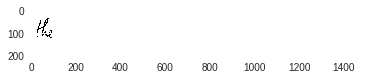

  the -> the


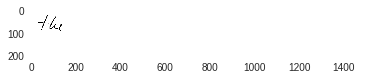

  the -> the


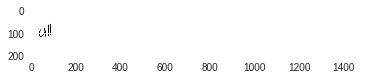

  all -> tnl
  Batch: 20 Loss: 2.0813474714756013


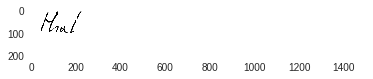

  that -> thet


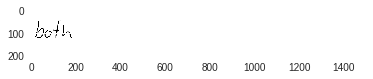

  both -> teth


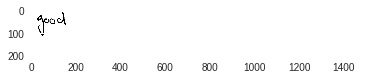

  good -> totd
  Batch: 40 Loss: 1.8936543603738152
Test loss: 1.939025
Training epoch 1...
  Batch: 30 Loss: 2.088000451193915
Discr loss: 1.010354
  Batch: 60 Loss: 1.8993609812524583
Discr loss: 0.666694
  Batch: 90 Loss: 1.985862011379666
Discr loss: 0.684251
  Batch: 120 Loss: 2.0046787712309095
Discr loss: 0.562216
  Batch: 150 Loss: 1.9697376290957134
Discr loss: 0.966375
  Batch: 180 Loss: 1.942208128505283
Discr loss: 0.436996
  Batch: 210 Loss: 1.8391815781593324
  Batch: 240 Loss: 2.0053946548038057
Discr loss: 0.395615
  Batch: 270 Loss: 2.003858274883694
Discr loss: 0.461507
  Batch: 300 Loss: 1.9890660842259724
  Batch: 330 Loss: 1.9363779399130079
Discr loss: 0.805387
  Batch: 360 Loss: 1.9680098666085137
Train loss: 1.960251
Testing...


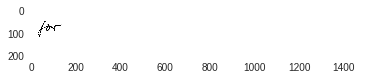

  for -> tor


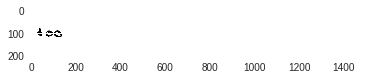

  too -> tho


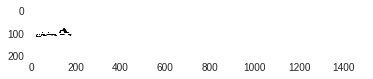

  and -> tnd
  Batch: 20 Loss: 2.038201105594635


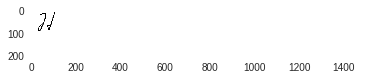

  It -> tt


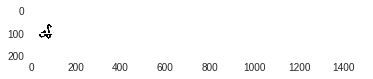

  of -> tf


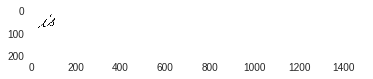

  is -> tn
  Batch: 40 Loss: 1.823132864634196
Test loss: 1.883578
Training epoch 2...
Discr loss: 0.541384
  Batch: 30 Loss: 2.0416893429226346
Discr loss: 0.463292
  Batch: 60 Loss: 1.973964560031891
Apply descr...
Discr loss: 0.766367
  Batch: 90 Loss: 1.9628826644685533
Discr loss: 0.923712
  Batch: 120 Loss: 1.9754121303558352
Discr loss: 0.560860
  Batch: 150 Loss: 1.8515647954410979
Discr loss: 0.471629
  Batch: 180 Loss: 1.8629238009452818
Discr loss: 0.468381
  Batch: 210 Loss: 1.944884563816918
Discr loss: 0.463593
  Batch: 240 Loss: 1.8996066874927942
Discr loss: 0.706558
  Batch: 270 Loss: 1.835943055152893
Discr loss: 0.818918
  Batch: 300 Loss: 2.0263364884588455
Discr loss: 0.857975
  Batch: 330 Loss: 1.8748855842484367
Discr loss: 0.857198
  Batch: 360 Loss: 1.841184259785546
Train loss: 1.918162
Testing...


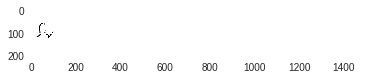

  Sir -> tor


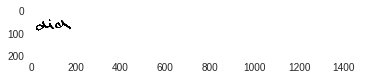

  did -> tod


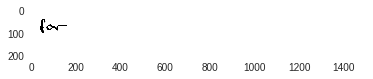

  for -> tor
  Batch: 20 Loss: 1.8774856011072796


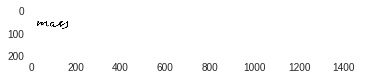

  mass -> want


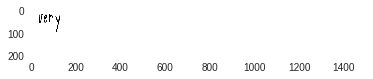

  very -> tere


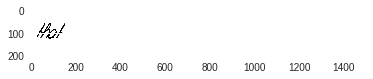

  that -> thet
  Batch: 40 Loss: 1.8970097223917641
Test loss: 1.841217
Training epoch 3...
Discr loss: 0.947148
  Batch: 30 Loss: 2.0140250749058195
Discr loss: 0.863970
  Batch: 60 Loss: 1.839881071779463
  Batch: 90 Loss: 1.8756107462777032
Discr loss: 0.412568
  Batch: 120 Loss: 1.8685150225957237
Discr loss: 0.536464
  Batch: 150 Loss: 1.9279822442266676
Discr loss: 0.801836
  Batch: 180 Loss: 1.840515383084615
Discr loss: 0.358536
  Batch: 210 Loss: 1.9281309631135728
Discr loss: 0.401616
  Batch: 240 Loss: 1.8368126299646166
  Batch: 270 Loss: 1.9573579205407037
Discr loss: 0.472313
  Batch: 300 Loss: 1.8637566910849677
Discr loss: 0.687507
  Batch: 330 Loss: 1.924319362640381
Discr loss: 0.412600
  Batch: 360 Loss: 1.9774430049790275
Train loss: 1.891473
Testing...


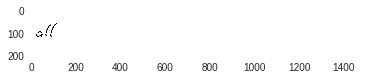

  all -> tnl


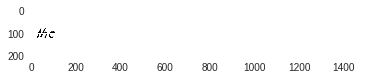

  the -> the


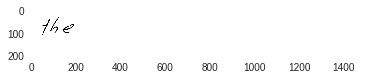

  the -> the
  Batch: 20 Loss: 1.9199740986029306
Test loss: 1.867474
Training epoch 4...
  Batch: 30 Loss: 1.8606919156180488
Discr loss: 0.982997
  Batch: 60 Loss: 1.936063157187568
Discr loss: 0.976968
  Batch: 90 Loss: 1.9208859390682642
  Batch: 120 Loss: 1.9294977400037978
Discr loss: 0.826138
  Batch: 150 Loss: 1.8373147341940135
Discr loss: 0.412317
  Batch: 180 Loss: 1.837692533599006
Discr loss: 0.612597
  Batch: 210 Loss: 1.9033442854881286
Discr loss: 1.014316
  Batch: 240 Loss: 1.8871433814366658
Discr loss: 1.002155
  Batch: 270 Loss: 1.8788378066486784
Discr loss: 0.343059
  Batch: 300 Loss: 1.906577161947886
Discr loss: 0.946674
  Batch: 330 Loss: 1.8652097225189208
Discr loss: 0.478947
  Batch: 360 Loss: 1.8923717088169523
Train loss: 1.881336
Testing...


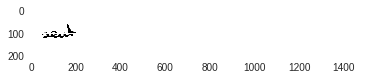

  sent -> taet


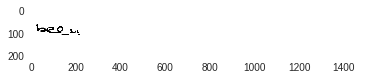

  been -> tuen


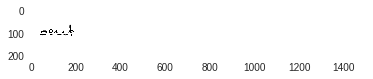

  sent -> taet
  Batch: 20 Loss: 1.8733964343865712


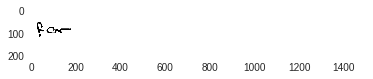

  for -> tor


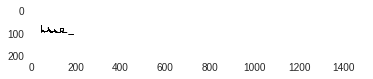

  the -> the


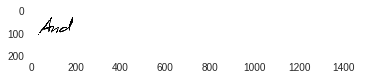

  And -> tnd
  Batch: 40 Loss: 1.8768501957257588
Test loss: 1.829389
Training epoch 5...
Discr loss: 0.714532
  Batch: 30 Loss: 1.8804833345943024
Discr loss: 0.376937
  Batch: 60 Loss: 1.9386087695757546
Discr loss: 0.577643
  Batch: 90 Loss: 1.823767246140374
Discr loss: 0.403212
  Batch: 120 Loss: 1.8171930299864874
Discr loss: 0.559907
  Batch: 150 Loss: 1.812764248583052
Discr loss: 0.685570
  Batch: 180 Loss: 1.9097393512725833
Discr loss: 0.826073
  Batch: 210 Loss: 1.9725961976581148
Discr loss: 0.696143
  Batch: 240 Loss: 1.8683442963494195
Discr loss: 0.647755
  Batch: 270 Loss: 1.9348513722419738
Discr loss: 0.958148
  Batch: 300 Loss: 1.7446150342623392
Discr loss: 0.501653
  Batch: 330 Loss: 1.8146711574660408
Discr loss: 0.768772
  Batch: 360 Loss: 1.949106768767039
Train loss: 1.864523
Testing...


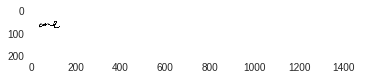

  one -> tfe


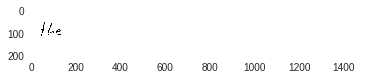

  the -> the


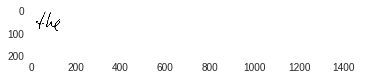

  the -> the
  Batch: 20 Loss: 1.9734240194161732
Test loss: 1.829818
Training epoch 6...
Discr loss: 0.851370
  Batch: 30 Loss: 1.9327236360973783
Discr loss: 0.731817
  Batch: 60 Loss: 1.773089145289527
Discr loss: 0.724865
  Batch: 90 Loss: 1.8516753474871317
  Batch: 120 Loss: 1.9178220854865178
  Batch: 150 Loss: 1.9225671026441786
Discr loss: 0.354189
  Batch: 180 Loss: 1.8763514969083996
Discr loss: 0.595912
  Batch: 210 Loss: 1.8036297784911262
Discr loss: 0.844970
  Batch: 240 Loss: 1.8055836240450545
Discr loss: 0.393612
  Batch: 270 Loss: 1.8337111433347064
Discr loss: 0.790766
  Batch: 300 Loss: 1.8995428376727637
Discr loss: 0.429036
  Batch: 330 Loss: 1.794586843914456
Apply descr...
Discr loss: 0.538544
  Batch: 360 Loss: 1.8218067169189451
Train loss: 1.851509
Testing...


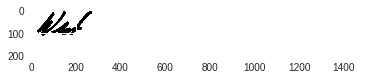

  West -> thlt


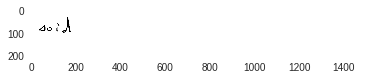

  said -> thid


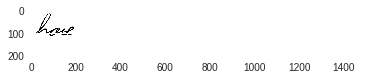

  have -> tade
  Batch: 20 Loss: 1.9758451600869495


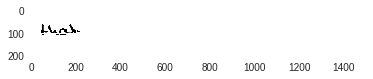

  that -> ahet


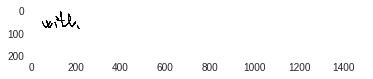

  with -> tath


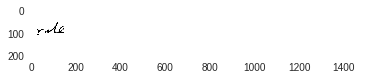

  role -> tomd
  Batch: 40 Loss: 1.7557103574275974
Test loss: 1.820271
Training epoch 7...
Discr loss: 0.417784
  Batch: 30 Loss: 1.8765831099616157
  Batch: 60 Loss: 1.8659113685290019
Apply descr...
Discr loss: 0.745810
  Batch: 90 Loss: 1.9424495471848382
Discr loss: 0.495773
  Batch: 120 Loss: 1.890961694717407
Discr loss: 0.869556
  Batch: 150 Loss: 1.7934604843457538
Discr loss: 0.820734
  Batch: 180 Loss: 1.8837554189893935
Discr loss: 0.608464
  Batch: 210 Loss: 1.9346886184480456
Apply descr...
Discr loss: 0.807490
  Batch: 240 Loss: 1.9871773719787598
Discr loss: 1.006706
  Batch: 270 Loss: 1.827652370929718
Discr loss: 0.509393
  Batch: 300 Loss: 1.8000510891278587
Discr loss: 0.791727
  Batch: 330 Loss: 1.736174015204112
Discr loss: 0.773286
  Batch: 360 Loss: 1.7453277892536587
Train loss: 1.846411
Testing...


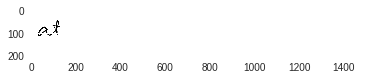

  at -> tn


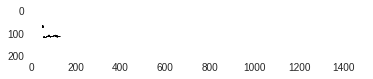

  in -> tn


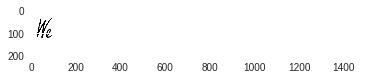

  We -> te
  Batch: 20 Loss: 1.8937799990177155
Test loss: 1.808080
Training epoch 8...
  Batch: 30 Loss: 1.932748764091068
Discr loss: 0.349177
  Batch: 60 Loss: 1.817956942982144
Discr loss: 0.572330
  Batch: 90 Loss: 1.786561761962043
Discr loss: 0.472090
  Batch: 120 Loss: 1.7988995260662504
Discr loss: 0.728249
  Batch: 150 Loss: 1.8407930546336706
Discr loss: 0.496688
  Batch: 180 Loss: 1.827716619438595
Apply descr...
Discr loss: 0.695291
  Batch: 210 Loss: 1.7798526459270054
Discr loss: 0.730558
  Batch: 240 Loss: 1.8750129792425367
  Batch: 270 Loss: 1.9060024804539148
Discr loss: 0.757124
  Batch: 300 Loss: 1.9145889666345384
Discr loss: 0.806021
  Batch: 330 Loss: 1.726837786038717
Apply descr...
Apply descr...
Apply descr...
Discr loss: 0.940346
  Batch: 360 Loss: 1.895681863360935
Train loss: 1.840002
Testing...


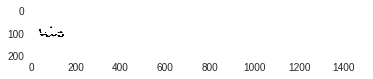

  his -> tas


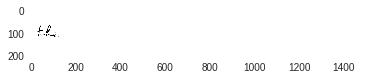

  the -> the


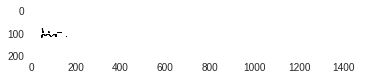

  Mr. -> tr.
  Batch: 20 Loss: 1.8803467094898223


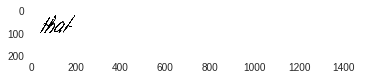

  that -> thet


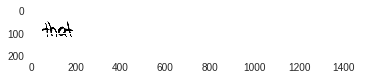

  that -> thet


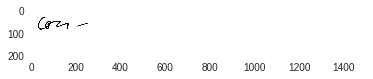

  con- -> tame
  Batch: 40 Loss: 1.8072355846563972
Test loss: 1.798821
Training epoch 9...
Discr loss: 0.617137
  Batch: 30 Loss: 1.836666328377194
Discr loss: 0.494544
  Batch: 60 Loss: 1.9385929716957941
Discr loss: 0.729319
  Batch: 90 Loss: 1.783183655473921
Discr loss: 0.323711
  Batch: 120 Loss: 1.8353185296058652
Discr loss: 0.596687
  Batch: 150 Loss: 1.9184731576177811
Discr loss: 0.591595
  Batch: 180 Loss: 1.8998017734951445
Discr loss: 0.276847
Apply descr...
  Batch: 210 Loss: 1.8080967624982198
Apply descr...
Discr loss: 0.848264
  Batch: 240 Loss: 1.7857983019616868
Discr loss: 0.571568
  Batch: 270 Loss: 1.747260467211405
Apply descr...
  Batch: 300 Loss: 1.8504039698176913
Discr loss: 0.806085
  Batch: 330 Loss: 1.8337237119674683
Apply descr...
Discr loss: 0.898942
  Batch: 360 Loss: 1.8426503631803723
Apply descr...
Train loss: 1.833138
Testing...


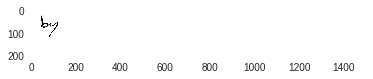

  by -> te


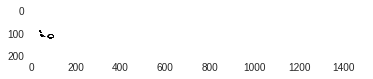

  to -> th


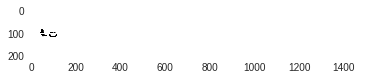

  to -> th
  Batch: 20 Loss: 1.993330055475235


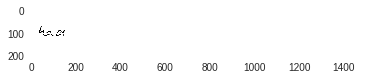

  had -> ted


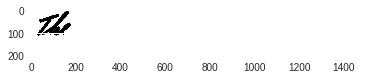

  The -> the


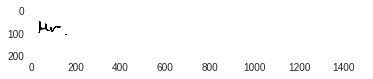

  Mr. -> tr.
  Batch: 40 Loss: 1.7127663274606069
Test loss: 1.807852
Training epoch 10...
Discr loss: 0.759627
  Batch: 30 Loss: 1.978946333461338
Discr loss: 0.727719
  Batch: 60 Loss: 1.8187464674313862
Discr loss: 0.870147
  Batch: 90 Loss: 1.7676633384492662
Apply descr...
Discr loss: 0.419291
  Batch: 120 Loss: 1.7624467187457613
Discr loss: 0.920138
  Batch: 150 Loss: 1.8479269703229266
Discr loss: 0.563454
  Batch: 180 Loss: 1.8618571546342637
Discr loss: 0.754147
  Batch: 210 Loss: 1.8834736347198489
Discr loss: 0.802653
  Batch: 240 Loss: 1.778197863366869
Discr loss: 0.442884
  Batch: 270 Loss: 1.807588243484497
  Batch: 300 Loss: 1.8590000430742901
Discr loss: 0.536845
  Batch: 330 Loss: 1.829062126742469
Apply descr...
Discr loss: 0.464129
  Batch: 360 Loss: 1.8573685977194043
Train loss: 1.827004
Testing...


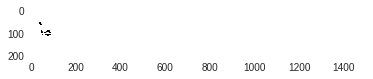

  is -> tn


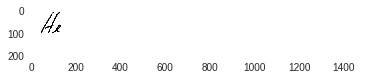

  He -> te


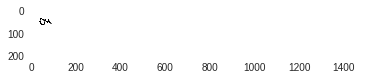

  on -> tn
  Batch: 20 Loss: 1.8548031846682231
Test loss: 1.786539
Training epoch 11...
Apply descr...
Discr loss: 0.481161
  Batch: 30 Loss: 1.8980336427688598
Apply descr...
Discr loss: 0.678185
  Batch: 60 Loss: 1.7655068000157677
Apply descr...
Apply descr...
Discr loss: 0.893458
  Batch: 90 Loss: 1.853765074412028
Apply descr...
  Batch: 120 Loss: 1.9096197883288066
Discr loss: 0.781487
  Batch: 150 Loss: 1.779968089527554
Discr loss: 0.758014
  Batch: 180 Loss: 1.7693210244178772
Apply descr...
Discr loss: 0.381201
  Batch: 210 Loss: 1.8691471801863777
Discr loss: 0.451997
  Batch: 240 Loss: 1.8331573949919806
Discr loss: 0.631628
  Batch: 270 Loss: 1.8467580133014256
Discr loss: 0.326359
  Batch: 300 Loss: 1.8731872810257804
Apply descr...
Discr loss: 0.636084
  Batch: 330 Loss: 1.7679446776707968
Discr loss: 0.711907
  Batch: 360 Loss: 1.8521919833289253
Apply descr...
Train loss: 1.825615
Testing...


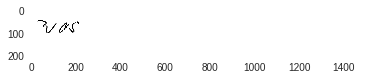

  was -> tis


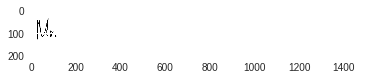

  Mr. -> tr.


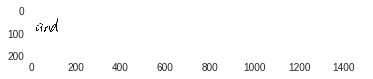

  and -> tnd
  Batch: 20 Loss: 1.9288129667441047
Test loss: 1.793018
Training epoch 12...
Discr loss: 0.628929
  Batch: 30 Loss: 1.9478756825129193
Discr loss: 0.382202
  Batch: 60 Loss: 1.8474159876505534
Discr loss: 0.302856
  Batch: 90 Loss: 1.7879020426008438
Discr loss: 0.687524
  Batch: 120 Loss: 1.794042174021403
Discr loss: 0.423257
  Batch: 150 Loss: 1.7820886347028944
Discr loss: 0.682029
  Batch: 180 Loss: 1.8545307728979321
Discr loss: 0.729990
  Batch: 210 Loss: 1.8241351180606422
Apply descr...
Apply descr...
Discr loss: 0.592098
  Batch: 240 Loss: 1.82164896859063
Discr loss: 0.499582
  Batch: 270 Loss: 1.7948723607593113
Discr loss: 0.705744
  Batch: 300 Loss: 1.7214547289742366
Discr loss: 0.830902
  Batch: 330 Loss: 1.8338079200850594
  Batch: 360 Loss: 1.8735815313127304
Train loss: 1.817258
Testing...


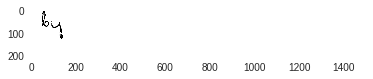

  by -> te


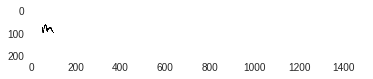

  in -> ts


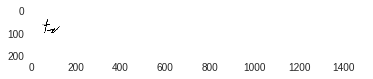

  to -> ah
  Batch: 20 Loss: 1.8869391520818073


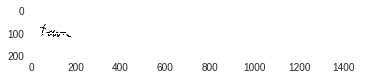

  town -> thln


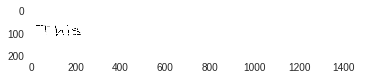

  This -> thes


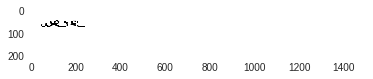

  were -> tire
  Batch: 40 Loss: 1.7741323192914327
Test loss: 1.785889
Training epoch 13...
Discr loss: 0.515248
  Batch: 30 Loss: 1.7827596571710378
Apply descr...
Discr loss: 0.513876
  Batch: 60 Loss: 1.8703190710809499
Apply descr...
Discr loss: 0.467261
  Batch: 90 Loss: 1.804828887515598
Apply descr...
Discr loss: 0.472469
  Batch: 120 Loss: 1.7990953538152905
  Batch: 150 Loss: 1.804660107029809
Apply descr...
Apply descr...
Discr loss: 0.339067
  Batch: 180 Loss: 1.946657347679138
Discr loss: 0.536464
  Batch: 210 Loss: 1.7185662918620637
Apply descr...
Discr loss: 0.642802
  Batch: 240 Loss: 1.8516808284653556
Discr loss: 0.719311
  Batch: 270 Loss: 1.7304497030046249
Discr loss: 0.814086
  Batch: 300 Loss: 1.8529872841305204
Discr loss: 0.983151
  Batch: 330 Loss: 1.9177511281437345
Discr loss: 0.615649
  Batch: 360 Loss: 1.7660411463843455
Train loss: 1.815832
Testing...


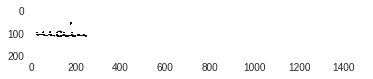

  main -> tann


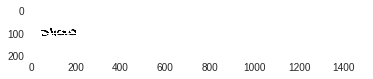

  show -> aoew


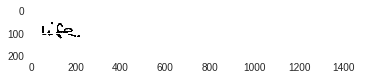

  life -> tike
  Batch: 20 Loss: 1.8659537454446156
Test loss: 1.788573
Training epoch 14...
Discr loss: 0.855660
  Batch: 30 Loss: 1.9925377329190574
Discr loss: 0.537631
  Batch: 60 Loss: 1.850117795997196
Discr loss: 0.782161
  Batch: 90 Loss: 1.7109954370392695
Discr loss: 0.404662
  Batch: 120 Loss: 1.793056217829386
Discr loss: 0.450332
  Batch: 150 Loss: 1.7659254630406698
Apply descr...
Discr loss: 0.354428
  Batch: 180 Loss: 1.8455396281348335
Discr loss: 0.654408
  Batch: 210 Loss: 1.7461007899708219
Discr loss: 0.357439
  Batch: 240 Loss: 1.838545987341139
Apply descr...
Discr loss: 0.381941
  Batch: 270 Loss: 1.7943918466567992
Apply descr...
  Batch: 300 Loss: 1.911614127953847
Discr loss: 0.423023
  Batch: 330 Loss: 1.7426217158635458
Apply descr...
Discr loss: 0.665002
  Batch: 360 Loss: 1.7802961415714689
Train loss: 1.807879
Testing...


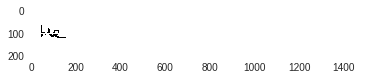

  He -> ae


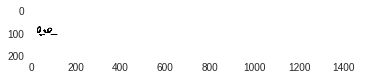

  be -> te


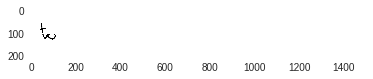

  to -> th
  Batch: 20 Loss: 1.883674645423889
Test loss: 1.761937
Training epoch 15...
Discr loss: 0.362759
  Batch: 30 Loss: 1.8283645841810439
Discr loss: 0.745832
  Batch: 60 Loss: 1.7917157755957709
Apply descr...
Discr loss: 0.704203
  Batch: 90 Loss: 1.8291594637764823
Discr loss: 0.630240
  Batch: 120 Loss: 1.7885543584823609
Discr loss: 0.554544
  Batch: 150 Loss: 1.9939753095308939
Discr loss: 0.834231
  Batch: 180 Loss: 1.771349260542128
Discr loss: 0.375062
  Batch: 210 Loss: 1.7672387520472208
Apply descr...
Apply descr...
Discr loss: 0.358869
  Batch: 240 Loss: 1.8861849890814886
Discr loss: 0.493518
  Batch: 270 Loss: 1.8778088357713487
Discr loss: 0.381331
  Batch: 300 Loss: 1.786535980966356
  Batch: 330 Loss: 1.7695309612486099
Discr loss: 0.765729
  Batch: 360 Loss: 1.8182820253902012
Train loss: 1.810242
Testing...


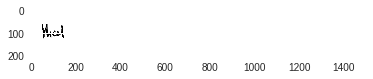

  that -> thet


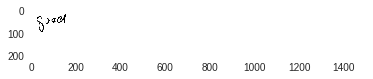

  good -> totd


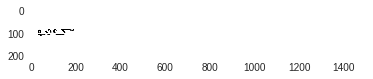

  ever -> taer
  Batch: 20 Loss: 1.8635647694269817
Test loss: 1.773872
Training epoch 16...
Discr loss: 0.647433
  Batch: 30 Loss: 1.9353101637628343
Discr loss: 0.408103
  Batch: 60 Loss: 1.864998687638177
Discr loss: 0.356210
  Batch: 90 Loss: 1.742729409535726
Apply descr...
Discr loss: 0.349090
  Batch: 120 Loss: 1.7853996872901914
Apply descr...
Discr loss: 0.538236
  Batch: 150 Loss: 1.7529447939660814
Discr loss: 0.445399
  Batch: 180 Loss: 1.6924620151519776
Discr loss: 0.496269
  Batch: 210 Loss: 1.8113208704524568
Discr loss: 0.747918
  Batch: 240 Loss: 1.8228681683540344


KeyboardInterrupt: ignored

In [0]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0.00005)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, weight_decay=0.00005)

criterion = nn.NLLLoss()

teacher_forcing_ratio = 1#0.5

from random import random

def train(epoch, max_size):
  print("Training epoch " + str(epoch) + "...")
  
  freq = 30
  
  train_set.to_start(max_size)
  batch_idx = 0
  c_loss = 0

  
  train_loss = 0
  
  while True:
    batch = train_set.make_batch()
    if batch is None:
      break
    
    orig_data, target = batch
    data = orig_data/255.0
    data = data.view(batch_size, 1, image_width, image_height).to(device)
    target = target.to(device)


    encoder.zero_grad()
    decoder.zero_grad()

    
    enc = encoder(data)
    #print(enc.shape)
    s = enc.permute(1, 0, 2)
    #print(s.shape)
    s = s.flatten(start_dim=1).view(1, batch_size, -1)
    
    
    discr_loss = 1
    if target.shape[1] > 1:
      discriminator_optimizer.zero_grad()
      _, _, tf_loss = apply_discriminator(s, target, True, True, batch_ones)
      _, _, fr_loss = apply_discriminator(s, target, False, True, batch_zeros)
      dl = tf_loss + fr_loss
      discr_loss = dl.item()
      if (batch_idx % freq == 0) and (batch_idx != 0):
        print("Discr loss: %f" %(dl.item()))
      #print(dl)
      dl.backward()
      discriminator_optimizer.step()
   

      #     use_teacher_forcing = True if random() < teacher_forcing_ratio else False
      # #    recognition_result, loss, discriminator_loss = apply_discriminator(s, target, use_teacher_forcing, True, batch_zeros)
      #     recognition_result, loss = apply_decoder(s, target, use_teacher_forcing)
    batch_loss = None  
    if (target.shape[1] > 1) and (discr_loss < 0.3):
      discriminator_optimizer.zero_grad()
      recognition_result, loss, discriminator_loss = apply_discriminator(s, target, True, False, batch_zeros)
      batch_loss = loss.item()
      loss = loss + discriminator_loss
      print("Apply descr...")
    else:
      recognition_result, loss = apply_decoder(s, target, True)
      batch_loss = loss.item()

      
      
    c_loss += batch_loss/(target.shape[1] + 0)
    train_loss += batch_loss/(target.shape[1] + 0)
    if (batch_idx % freq == 0) and (batch_idx != 0):
      
      if False:#True:#not use_teacher_forcing:
        for k in range(0, min(3, target.shape[0])):
            decoded = recognition_result[k,0:target.shape[1]]
            plt.imshow(orig_data[k].cpu(), cmap="gray")
            plt.show()
            print("  " + train_set.decode_word(target[k,:]) + " -> " + train_set.decode_word(decoded))
      c_loss /= freq 
      print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
      c_loss = 0
    loss.backward()
    #grad_clip = 0.1
    #torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    #torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    batch_idx += 1
  print("Train loss: %f"%(train_loss/batch_idx))

for i in range(0, 100):
  max_size = 5
  train(i, max_size)
  test(max_size)